In [1]:
#loading the necessary packages


import numpy as np # for linear data
import pandas as pd # data processing, csv files i/o



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py



  

wap = ( BidPrice∗AskSize + AskPrice∗BidSize) / (BidSize+AskSize)

target = ( (StockWAP[t+60] / StockWAP [t]) − (IndexWAP [t+60] IndexWAP [t]) )∗10000

- columns:
    1. date_id = days
    2. seconds_in_bucket = final ::: 10 minutes -> 600 seconds
    

In [2]:
## Looking at data

In [3]:
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

# 1.Data Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

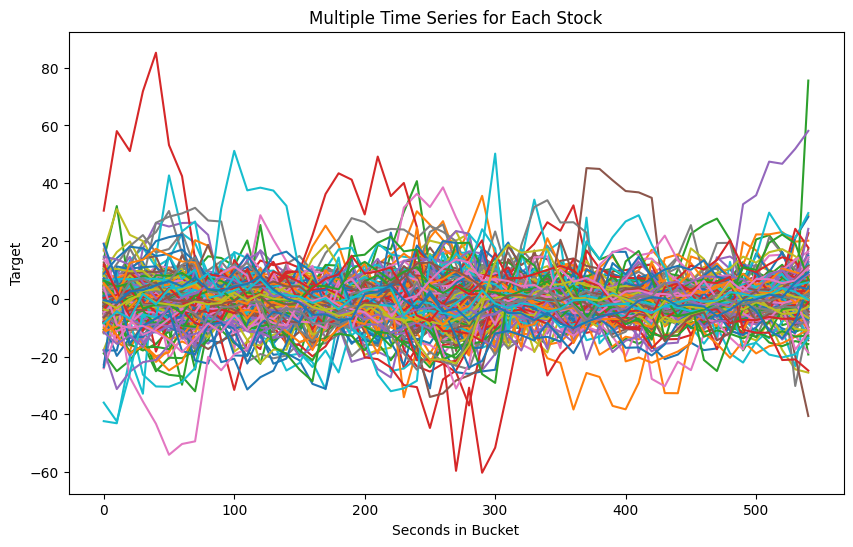

In [5]:
# Ploting time series for target in day 0 

df_plt = (
    df
    .query('date_id == 0')
    [['stock_id', 'target', 'seconds_in_bucket']]
)

plt.figure(figsize=(10, 6))

for stock in df_plt['stock_id'].unique():
    df_stock = df_plt[df_plt['stock_id'] == stock]
    plt.plot(df_stock['seconds_in_bucket'], df_stock['target'], label=f'Stock {stock}')

plt.xlabel('Seconds in Bucket')
plt.ylabel('Target')
plt.title('Multiple Time Series for Each Stock')
plt.show()

<Axes: title={'center': 'Bid and Ask over the stock and day 0'}, xlabel='seconds_in_bucket'>

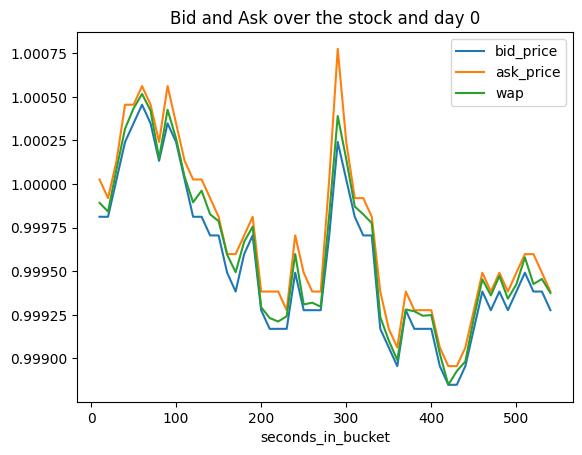

In [7]:
# Ploting the bid and ask price to stock and day 0

(
    df
    .query('stock_id == 0 & date_id == 0')
    [['seconds_in_bucket','bid_price','ask_price', 'wap']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title = 'Bid and Ask over the stock and day 0')
)

<Axes: title={'center': 'Stock 0 on Day 0 - Ploting the near, far and reference prices'}, xlabel='seconds_in_bucket'>

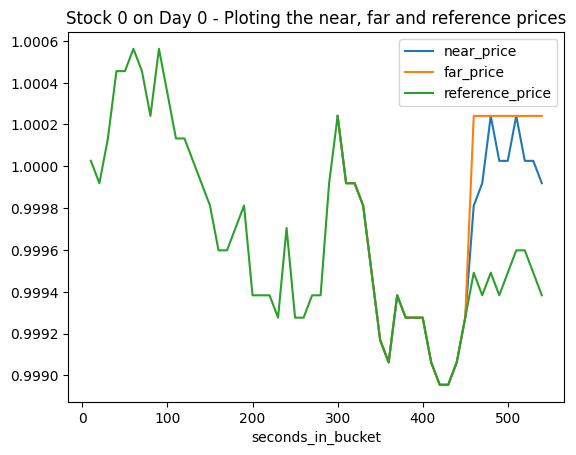

In [8]:
# Ploting the near, far and reference prices

(
    df
    .query('stock_id ==0 & date_id ==0')
    [['seconds_in_bucket','near_price','far_price','reference_price']]
    .replace(0, np.nan)
    .set_index('seconds_in_bucket')
    .plot(title = 'Stock 0 on Day 0 - Ploting the near, far and reference prices')
)

<Axes: title={'center': 'Stock 0 on Day 0 - Imbalance and matched'}, xlabel='seconds_in_bucket'>

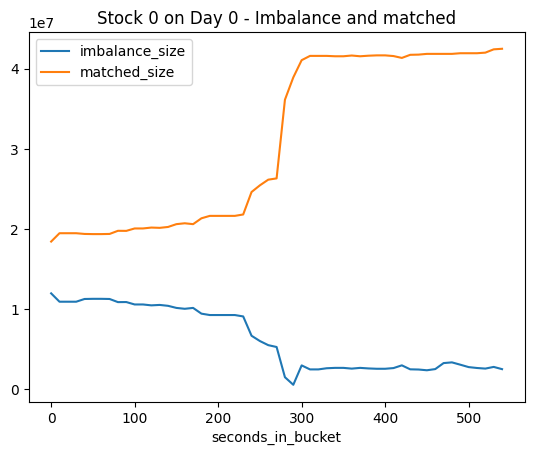

In [9]:
# Imbalance and matched size plotting

(
    df
    .query('stock_id == 3 & date_id ==0')
    [['seconds_in_bucket','imbalance_size','matched_size']]
    .set_index('seconds_in_bucket')
    .plot(title='Stock 0 on Day 0 - Imbalance and matched')
)

# Feature engineering

In [10]:
def feature_cols(df):
    columns = [col for col in df.columns if col not in ['row_id', 'time_id', 'date_id', 'stock_id', 'currently_scored']]
    return df[columns]

In [11]:
df.fillna(0, inplace=True)

In [12]:
x_train = feature_cols(df.drop(columns='target'))
x_train.fillna(0, inplace = True)

In [13]:
y_train = df['target'].values

# Splitting the data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, x_test, Y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Modelling

In [16]:
# Created the modeling with lgbm regressors 

In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb
from lightgbm import LGBMRegressor

pd.set_option("display.max_columns", None)

In [18]:
from sklearn.pipeline import Pipeline, FunctionTransformer

model = lgb.LGBMRegressor(objective='mae', n_estimators=200, random_state=55)

pipe = Pipeline([
    ('select_features', FunctionTransformer(feature_cols, validate=False)),
    ('model', model)
])

In [19]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('select_features',
                 FunctionTransformer(func=<function feature_cols at 0x7c9a398be440>)),
                ('model',
                 LGBMRegressor(n_estimators=200, objective='mae',
                               random_state=55))])

In [21]:
## Validating the model

y_pred = pipe.predict(x_test)

In [22]:
mae = mean_absolute_error(y_test, y_pred)

print(mae)

6.290888153945929
